# <u>Walmart Product Review Analysis <u/>

### Goal
This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 
### Notebook
Notebook ```2_walmart_product_review_nlp``` has cleaned the text and generated additional features. This notebook is for modeling determine the validity of the dataset and potentially extract features to explain why items are recommended or not recommended. 

In [1]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
import gensim
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Sats and Modeling packages
from sklearn import metrics
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import pickle
import warnings
warnings.filterwarnings("ignore") 


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [2]:
filename = "data/modeling_df.pkl"

In [3]:
infile = open(filename,"rb")
df = pickle.load(infile)
infile.close()

In [4]:
# confirming dataframe is not corrupted
df.head(2)

,item_name,price,overall_rating,num_rating,recommend,review_text,section,target,rating_bin,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing,0,1,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing,1,1,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000


In [5]:
# confirming dataframe has no new null values. 
df.isna().sum()

item_name            0
price                0
overall_rating       0
num_rating           0
recommend            0
review_text          0
section              0
target               0
rating_bin           0
clean_review_text    0
tokenized            0
rem_stop             0
lemma_words          0
delisted             0
girls'               0
men's                0
women's              0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6     

Now that we have cleaned the continuous variables, tokenized the raw text, removed stopwords, lemmatized words to their roots and generated LDA Topic scores, we can dive into modeling.

# Train Test Split

Item name, review text, clean review text,  features will be dropped because we cannot run strings in the model. 
They were generated simply for keeping track of feature engineering.  

In [6]:
drop_features = ["item_name", "overall_rating", "rating_bin", "recommend",
                 "clean_review_text", "review_text", "section", "tokenized", 
                 "rem_stop", "lemma_words", "target"]

In [7]:
X = df.drop(columns = drop_features)
y = df["target"].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(919, 36) (919,) (230, 36) (230,)


# Stopwords

In [10]:
# Extracted the stopwords from my preprocessing notebook to be used for the TfidfVectorizer
eda_stopwords = ["nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

# CountVectorizer

I ran a CountVectorizer to experiment and TFIDF performed better. However, if you would like to try, you can uncomment the cell below and run it. But please comment out the TfidfVectorizer cell. 

In [11]:
# # CountVec
# countvec = CountVectorizer(stop_words = stop_words, analyzer="word", ngram_range=(1,2), max_features=5000)
# train_vec = countvec.fit_transform(X_train.delisted.values).toarray()
# test_vec = countvec.fit_transform(X_test.delisted.values).toarray()


# count_train = pd.DataFrame(train_vec, columns = countvec.get_feature_names())
# count_test = pd.DataFrame(test_vec, columns = countvec.get_feature_names())

# print(f"X train shape: {X_train.shape}, Count train shape: {count_train.shape}") 
# print("-"*20)
# print(f"X test shape: {X_test.shape}, Count test shape: {count_test.shape}")

# # resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

# frame1 = [X_train, count_train]
# frame2 = [X_test, count_test]

# X_train = pd.concat(frame1, axis=1)
# X_test = pd.concat(frame2, axis=1)

# TfidfVectorizer

The reason for doing TfidfVectorizer after Train-Test Split is to prevent data leakage. 

In [12]:
tfidfvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features=2000, use_idf=True)  

train_vec = tfidfvec.fit_transform(X_train.delisted.values).toarray()
test_vec = tfidfvec.transform(X_test.delisted.values).toarray()

tfidf_train = pd.DataFrame(train_vec, columns = tfidfvec.get_feature_names())
tfidf_test = pd.DataFrame(test_vec, columns = tfidfvec.get_feature_names())

print(f"X train shape: {X_train.shape}, Tfidf train shape: {tfidf_train.shape}") 
print("-"*20)
print(f"X test shape: {X_test.shape}, Tfidf test shape: {tfidf_test.shape}")

# resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

frame1 = [X_train, tfidf_train]
frame2 = [X_test, tfidf_test]

X_train = pd.concat(frame1, axis=1)
X_test = pd.concat(frame2, axis=1)

X_train.head(2)

X train shape: (919, 36), Tfidf train shape: (919, 2000)
--------------------
X test shape: (230, 36), Tfidf test shape: (230, 2000)


,price,num_rating,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,able,able wear,absolute,absolutely,absolutely love,according,accurate,across,active,actual,actually,actually fit,add,added,addition,adjust,adjustable,adjustable waist,adorable,adult,advertised,affordable,afraid,age,ago,air,allow,allows,almost,almost like,alone,along,alot,already,also,also like,also love,also ordered,although,always,amazing,amount,ankle,annoying,another,another brand,another color,anymore,anyone,anything,anyway,anywhere,apart,apparently,appear,appearance,appears,appreciate,appropriate,area,arm,armpit,around,around ankle,around house,around leg,around waist,arrive,arrived,asked,athletic,attached,attractive,available,average,aware,away,awesome,awful,baby,back,back pocket,bad,bag,baggy,ball,band,barely,barely fit,bargain,base,based,basic,basically,battery,bc,beat,beat price,beautiful,beautiful color,beautifully,become,bed,begin,behind,believe,belly,belt,belt loop,bend,best,better,better expected,better quality,...,warm winter,warm without,warmer,warmth,wash,wash cold,wash dry,wash wear,wash well,washable,washed,washed cold,washed dried,washed well,washed yet,washer,washing,washing drying,wasnt,waste,waste money,water,wear,wear around,wear bought,wear day,wear every,wear fit,wear jean,wear large,wear legging,wear like,wear long,wear love,wear medium,wear ordered,wear size,wear small,wear sock,wear sweater,wear time,wear well,wear work,wearing,weather,website,week,weigh,weight,weight fabric,weird,well,well comfortable,well good,well like,well look,well love,well made,well wash,well worth,went,went back,went size,wet,whatever,white,whole,wicking,wide,wider,width,wife,wind,wine,winter,winter coat,winter month,wire,wise,wish,wish came,wish color,wish would,within,without,woman,woman plus,woman size,wonder,wonder nation,wonderful,wont,word,wore,work,work well,worked,working,workout,world,worn,worried,worry,worse,worst,worth,worth money,worth price,would,would better,would buy,would fit,would give,would highly,would like,would look,would love,would make,would never,would nice,would order,would perfect,would purchase,would recommend,would say,would size,wrangler,wrap,wrinkle,wrist,wrong,wrong size,xxl,yard,yeah,year,year ago,year old,year round,yes,yet,yo,yoga,yoga pant,young,yr,yr old,zero,zip,zipper
0,11.94,13.0,"thick, material, quality, product, great, pric...",1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157222,0.0,0.0,0.0,0.0,0.090021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062148,0.144774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.00,3.0,"hoodie, little, thinner, side, daughter, love,...",1.0,0.0,0.0,0.0,0.0,0.052284,0.0,0.0,0.0,0.909611,0.0,0.0,0.0,0.0,0.0,0.052284,0.0,0.0,0.0,0.909611,0.0,0.

In [13]:
# Dropping "delisted" from both Train and Test because these have already been Vectorized. 
X_train.drop(columns = ["delisted"], inplace = True)
X_test.drop(columns = "delisted", inplace=True)
X.drop(columns = ["delisted"], inplace = True)

In [14]:
def model_metrics(y_test, y_pred):

    '''Shows Accuracy, Precision, Recall, and F1-Score evaluation metrics'''

    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)));

In [15]:
def cross_validation(model, X_train, y_train, cv=5, n_jobs=-1):
    '''Prints cross-validation metrics for evaluation'''

    score = cross_val_score(model, X_train, y_train, cv=cv, scoring = "f1", n_jobs=n_jobs)
    print('Cross-Validation F1 Scores:', score)
    print('Mean F1 Scores: ', round(score.mean(), 5));

In [16]:
def con_mat(X, y, title=None):
    cm = confusion_matrix(X, y)
    fig, ax = plt.subplots(figsize = (6,4))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Not Recommended', 'Recommended'])
    ax.set_yticklabels(['Not Recommended', 'Recommended'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    return plt.show();

# Dummy Classifier

In [17]:
dummy_clf = DummyClassifier(strategy="stratified")

In [18]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

Evaluation Metrics:
Accuracy: 0.5652173913043478
Precision: 0.7283950617283951
Recall: 0.6781609195402298
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.8125     0.59259259 0.60606061 0.8        0.64516129 0.8125
 0.5        0.68571429 0.66666667 0.70588235]
Mean F1 Scores:  0.68271
------------------------------------------------------------


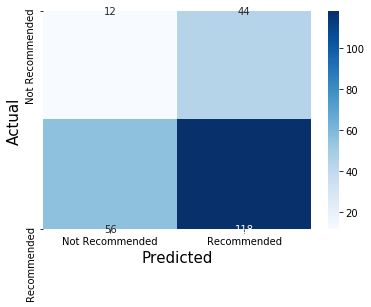

In [19]:
y_preds_dum = dummy_clf.predict(X_test)
print(model_metrics(y_test, y_preds_dum));                 
print("-"*60)
cross_validation(dummy_clf, y_test, y_preds_dum, cv=10)
print("-"*60)
con_mat(y_test, y_preds_dum, title="Dummy Classifier")

Accuracy for dummy is a bit higher than expected (expected to be near 50%). Additionally, there is a good amount of False Negative and False positive in the confusion matrix. This might be due to the class imbalance. Mean F1 score of 0.713 can also be explained due to the class imbalance.

I will use class_weight="balanced" to combat this. 

# Logistic Regression Baseline
Only added parameters are random_state=0 and n_jobs=-1. 
- random_state=0 for reproducibility and consistency across model comparisions. 
- n_jobs=-1 to use all cores to run the models as fast as possible. 

Evaluation Metrics:
Accuracy: 0.7956521739130434
Precision: 0.8009478672985783
Recall: 0.9712643678160919
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85618729 0.85714286 0.84949833 0.85714286 0.85148515]
Mean F1 Scores:  0.85429
------------------------------------------------------------


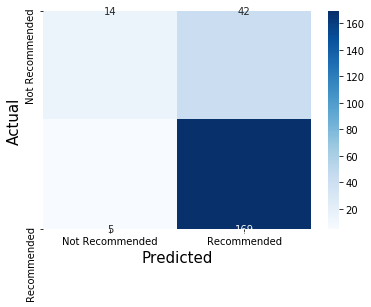

In [20]:
logreg_clf = LogisticRegression(random_state = 0,n_jobs=-1)
logreg_clf.fit(X_train, y_train)

y_pred_lr = logreg_clf.predict(X_test)
print(model_metrics(y_test, y_pred_lr))
print("-"*60)
cross_validation(logreg_clf, X_train, y_train)
print("-"*60)
con_mat(y_test, y_pred_lr, title="Logistic Regression")

Although we acheive a decent F1 score of 0.85, the class imabalnce is causing the model to lean in favor of the dominant class. The recall score is at 0.97, which means that when it's actually "recommended", our model predict correctly 97% of the time. This is pretty good. However, the True negative rate is really low. There are 56 cctual Non Recommended items but only 19 were predicted and of those 19, only 14 were correct. 

So overall, not a bad baseline. But lets see how the balancing the classes affects the results.

# Logistic Regression with Class weight as Balanced
Only parameter added in class_weight='balanced'. This parameter will tackle the class imbalance.  

In [21]:
logreg_clf2 = LogisticRegression(random_state = 0,n_jobs=-1, class_weight="balanced")
logreg_clf2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=0)

Evaluation Metrics:
Accuracy: 0.7869565217391304
Precision: 0.9032258064516129
Recall: 0.8045977011494253
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.768      0.80916031 0.81300813 0.72881356 0.78787879 0.86363636
 0.80952381 0.828125   0.88888889 0.75409836]
Mean F1 Scores:  0.80511
------------------------------------------------------------


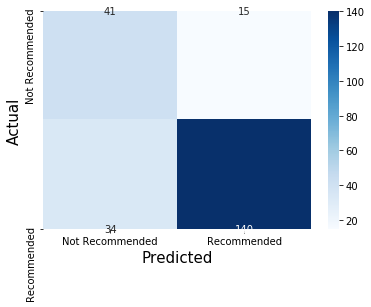

In [22]:
y_pred_lr2 = logreg_clf2.predict(X_test)
print(model_metrics(y_test, y_pred_lr2))
print("-"*60)
cross_validation(logreg_clf2, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_lr2, title="Logistic Regression")

Although F1 score is still faily high at 0.805 after balancing the class weight, the recall dropped by 0.17 and False Negative also increased. The Model predicted 75 items as not recommened items, when only 56 items are actual not recommended items. Out of 75 items, 41 were predicted correctly, which is higher than previous model. Therefore, actual Non Recommended items were predicted correctly at a higher rate. Since, Walmart has a ton of items, falsly predicting some recommended items as not recommended does not hurt drastically. We still have a decent precision rate at 0.90. Precision rate is calucated by answering, When model predicted Recommended, how often is it correct? So, predicting corretly at 90% is still a win.  

# GridSearchCV on Logistic Regression 
we can pass in multiple ranges of parameters to see at which parameters the model performs best. 

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   49.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


------------------------------------------------------------
{'C': 5, 'penalty': 'l2', 'tol': 7}
------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.7391304347826086
Precision: 0.9014084507042254
Recall: 0.735632183908046
None
------------------------------------------------------------


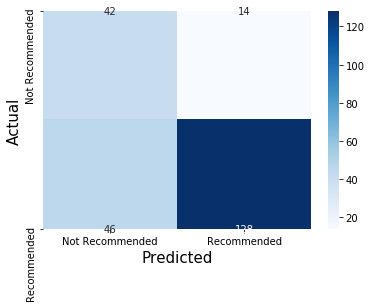

In [23]:
logreg = LogisticRegression(random_state = 0, n_jobs=-1, verbose=2, class_weight="balanced")
log_dict = {'tol': range(1,9,1), 'C': range(3,8), 'penalty': ["l1", "l2"]}
grid_log = GridSearchCV(logreg, log_dict, cv=10, scoring="f1", verbose=2, n_jobs=-1)
grid_log.fit(X_train, y_train)
print("-"*60)
print(grid_log.best_params_)
print("-"*60)
grid_log_pred = grid_log.predict(X_test)
print(model_metrics(y_test, grid_log_pred))
print("-"*60)
con_mat(y_test, grid_log_pred, title="Grid Search with Logistic Regression")

In [25]:
print(f"The best performing hyperparameters for GridSeachCV using Logistic Regression is the following: {grid_log.best_estimator_}. Resulting in a F1 score of {metrics.f1_score(y_test, grid_log_pred)}")

The best performing hyperparameters for GridSeachCV using Logistic Regression is the following: LogisticRegression(C=5, class_weight='balanced', n_jobs=-1, random_state=0,
                   tol=7, verbose=2). Resulting in a F1 score of 0.810126582278481


F1 score went up to 0.837, which is an increase of 0.032 using the best parameters. Although the accuracy of the model decreased, we still have a decent precision rate at 0.90 (predicting corretly at 90%). 

Lets see how other models perform

### There are three types of Naive Bayes models that we can run. 
- Gaussian: assumes that the features follow a normal distribution
- Bernoulli: useful only if featuer vectors are binary (0 and 1). 
- Multinomial: used for discrete counts. 

Since most of my features are in range of 0 and 1, Brenoulli Naive Bayes makes more sense. But I will try baseline for both Multinomial and Bernoulli. 


# Multinomial Naive Bayes Baseline

In [26]:
M_nb = MultinomialNB()
M_nb.fit(X_train, y_train)

MultinomialNB()

Evaluation Metrics:
Accuracy: 0.3652173913043478
Precision: 0.7258064516129032
Recall: 0.25862068965517243
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.28235294 0.23529412 0.35555556 0.42553191 0.46938776 0.48421053
 0.48421053 0.51612903 0.53061224 0.66037736]
Mean F1 Scores:  0.44437
------------------------------------------------------------


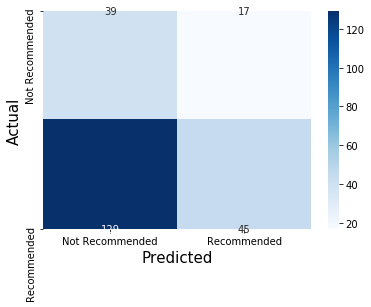

In [27]:
y_pred_Mnb = M_nb.predict(X_test)
print(model_metrics(y_test, y_pred_Mnb))
print("-"*60)
cross_validation(M_nb, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_Mnb, title="MultinomialNB")

Wow! Multinomial performs terribly... The dummy classifier does a better job... Perhaps tuning the model would increase the score. But in the interest of time, lets see how BrenoulliNB performs. If BrenoulliNB performs better, I will ignore MultinomialNB and work with BernoulliNB.

# Bernoulli Naive Bayes Baseline

In [28]:
B_nb = BernoulliNB()
B_nb.fit(X_train, y_train)

BernoulliNB()

Evaluation Metrics:
Accuracy: 0.782608695652174
Precision: 0.8647058823529412
Recall: 0.8448275862068966
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.81751825 0.78461538 0.83211679 0.81538462 0.8137931  0.85496183
 0.84210526 0.8        0.78195489 0.71212121]
Mean F1 Scores:  0.80546
------------------------------------------------------------


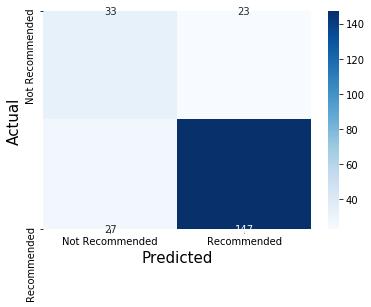

In [29]:
y_pred_Bnb = B_nb.predict(X_test)
print(model_metrics(y_test, y_pred_Bnb))
print("-"*60)
cross_validation(B_nb, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_Bnb, title="MultinomialNB")


BrenoulliNB performs a lot better than MultinomialNB. However, the BrenoulliNB baseline F1 score (0.805) is still less than Logistic Regression baseline F1 score (0.85).

# Bernoulli Naive Bayes with parameter tuning

In [30]:
B_nb2 = BernoulliNB(alpha=0.5) #alpha=1.0 by default. closer to 0, the less smoothing 
B_nb2.fit(X_train, y_train)

BernoulliNB(alpha=0.5)

Evaluation Metrics:
Accuracy: 0.7869565217391304
Precision: 0.8654970760233918
Recall: 0.8505747126436781
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.76691729 0.7751938  0.82962963 0.82442748 0.8        0.86363636
 0.85714286 0.81690141 0.82089552 0.76811594]
Mean F1 Scores:  0.81229
------------------------------------------------------------


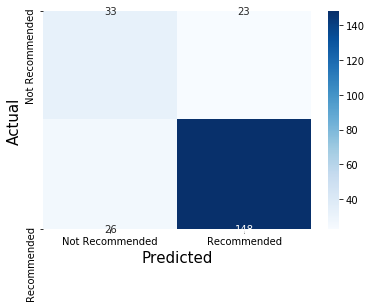

In [31]:
y_pred_Bnb2 = B_nb2.predict(X_test)
print(model_metrics(y_test, y_pred_Bnb2))
print("-"*60)
cross_validation(B_nb2, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_Bnb2, title="MultinomialNB")

We reduced the alpha parameter by half but the scores did not increase dramatically. We see an small increase of 0.00683 in the F1 score (0.812). Another way to balance the class imbalance would be to upsample the miniorty class (not recommended items). However, we already have a Logistic Regression Classifer that is performing at F1 score of 0.83 and prediciting correctly at 90%. Additionally, Logistic Regression is an interpretable model.   

# Support Vector Classifier Baseline

In [32]:
from sklearn.svm import SVC

In [33]:
clf_svc = SVC()
clf_svc.fit(X_train, y_train)

SVC()

Evaluation Metrics:
Accuracy: 0.7565217391304347
Precision: 0.7565217391304347
Recall: 1.0
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.8427673  0.8427673  0.83544304 0.83544304 0.83544304 0.83544304
 0.83544304 0.83544304 0.83544304 0.84076433]
Mean F1 Scores:  0.83744
------------------------------------------------------------


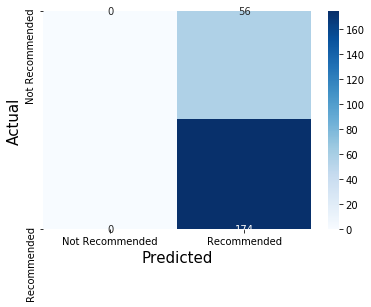

In [34]:
y_pred_rbf = clf_svc.predict(X_test)
print(model_metrics(y_test, y_pred_rbf))
print("-"*60)
cross_validation(clf_svc, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_rbf, title="MultinomialNB")

Baseline for Support Vector Classifier leans very heavily towards the majority class. Adding class_weight='balanced' should resolve this issue. 

In [35]:
clf_svc2 = SVC(class_weight="balanced")
clf_svc2.fit(X_train, y_train)

SVC(class_weight='balanced')

Evaluation Metrics:
Accuracy: 0.7347826086956522
Precision: 0.7810945273631841
Recall: 0.9022988505747126
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85714286 0.85714286 0.84768212 0.80821918 0.79432624 0.83116883
 0.80263158 0.78378378 0.80536913 0.78911565]
Mean F1 Scores:  0.81766
------------------------------------------------------------


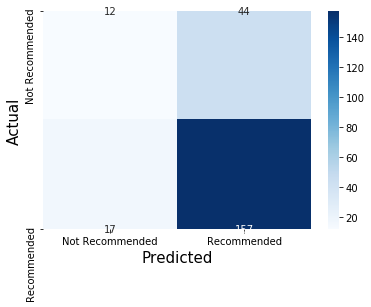

In [36]:
y_pred_svc2 = clf_svc2.predict(X_test)
print(model_metrics(y_test, y_pred_svc2))
print("-"*60)
cross_validation(clf_svc2, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_svc2, title="MultinomialNB")

Class_wight="balanced" does help but we have a low amount of True Negatives. The Flase positive and Flase negative rates are higher. 

# GridSearchCV with SVC

In [40]:
clf_svc2 = clf_svc2 = SVC(class_weight="balanced", random_state=0, probability="True")
svc2_dict = {'C': range(3,8)}
grid_svc = GridSearchCV(clf_svc2, svc2_dict, cv=10, scoring="f1", verbose=2, n_jobs=-1)
grid_svc.fit(X_train, y_train)
print("-"*60)
print(grid_svc.best_params_)
print("-"*60)
grid_svc_pred = grid_log.predict(X_test)
print(model_metrics(y_test, grid_svc_pred))
print("-"*60)
con_mat(y_test, grid_svc_pred, title="Grid Search with SVC")

TypeError: an integer is required

In [ ]:
print(f"The best performing hyperparameters for GridSeachCV using SVC is the following: {grid_svc.best_estimator_}. Resulting in a F1 score of {metrics.f1_score(y_test, grid_svc_pred)}")

# Random Forest Classifier Baseline

In [41]:
rfc_classifier = RandomForestClassifier()

------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.8130434782608695
Precision: 0.8164251207729468
Recall: 0.9712643678160919
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85333333 0.83221477 0.83870968 0.86666667 0.84210526 0.87837838
 0.87837838 0.8627451  0.8590604  0.8590604 ]
Mean F1 Scores:  0.85707
------------------------------------------------------------


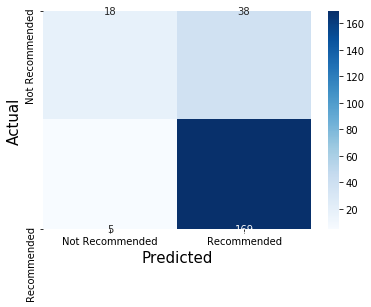

In [42]:
rfc_classifier.fit(X_train, y_train)
y_pred_RF = rfc_classifier.predict(X_test)
print("-"*60)
print(model_metrics(y_test, y_pred_RF))
print("-"*60)
cross_validation(rfc_classifier, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_RF, title="Random Forest")

# Random Forest Classifier with Tuning

------------------------------------------------------------
Evaluation Metrics:
Accuracy: 0.7913043478260869
Precision: 0.794392523364486
Recall: 0.9770114942528736
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85333333 0.82432432 0.8516129  0.85333333 0.84415584 0.85714286
 0.86092715 0.85714286 0.87417219 0.87248322]
Mean F1 Scores:  0.85486
------------------------------------------------------------


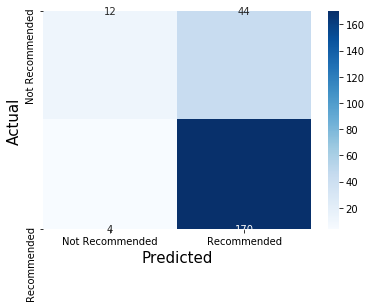

In [44]:
rfc_classifier2 = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0, class_weight="balanced")
rfc_classifier2.fit(X_train, y_train)
y_pred_RF2 = rfc_classifier2.predict(X_test)
print("-"*60)
print(model_metrics(y_test, y_pred_RF2))
print("-"*60)
cross_validation(rfc_classifier2, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_RF2, title="Random Forest")

# GridSearchCV with Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators = 300, criterion = "entropy",
                             random_state = 0, verbose=1, n_jobs=-1, class_weight="balanced")

param_dict={'min_samples_leaf':range(1,10,1), 'max_depth': range(1,10,1), "max_leaf_nodes":range(5,11,1)}

grid_tree = GridSearchCV(rfc, param_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min


In [ ]:
grid_tree_pred = grid_tree.predict(X_test)

print("-"*60)
print(model_metrics(y_test, grid_tree_pred))
print("-"*60)
con_mat(y_test, grid_tree_pred, title="Random Forest")

print("-"*60)
print(grid_tree.best_params_)
print("-"*60)

print(grid_tree.best_estimator_.feature_importances_)

In [ ]:
print(f"The best performing hyperparameters for GridSeachCV using SVC is the following: {grid_tree.best_estimator_}. Resulting in a F1 score of {metrics.f1_score(y_test, grid_tree_pred)}")

In [ ]:
print("Logistic Regression:")
print("Logistic Regression Baseline F1 score is:", metrics.f1_score(y_test, y_pred_lr))
print("Logistic Regression 2.0 F1 score is:", metrics.f1_score(y_test, y_pred_lr2))
print("GridSearchCV w/ Logistic Regression F1 score is:", metrics.f1_score(y_test, grid_log_pred))
print("="*60)
print("Bernoulli NB:")
print("BernoulliNB Baseline F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
print("BernoulliNB 2.0 F1 score is:", metrics.f1_score(y_test, y_pred_Bnb2))
print("="*60)
print("Support Vector Classifier:")
print("SVC Baseline F1 score is:", metrics.f1_score(y_test, y_pred_rbf))
print("SVC 2.0 F1 score is:", metrics.f1_score(y_test, y_pred_svc2))
print("GridSearchCV w/ Support Vector Classifier F1 score is:", metrics.f1_score(y_test, grid_svc_pred))
print("="*60)
print("Random Forest:")
print("Random Forest Baseline F1 score is:", metrics.f1_score(y_test, y_pred_RF))
print("Random Forest 2.0 F1 score is:", metrics.f1_score(y_test, y_pred_RF2))
print("GridSearchCV w/ Random Forest F1 score is:", metrics.f1_score(y_test, grid_tree_pred))

The top three models that performed the best are RandomForest, Bernoulli Naive Bayes and Logistic Regression. I will use the GridSearch with Logistic Regression and RandomForest to see what the best parameters are and how the score changes. 

Interesting! RandomForest performed better than GridSearchCV with RandomForest. I will extract the feature importance from this to see how it comapres with Logistic Regression coefficients. 

# Overall Scores using TFIDF

In [ ]:
# from matplotlib.ticker import FormatStrFormatter
# fig, ax = plt.subplots(figsize=(12,8))
# x = ["Logistic", "Bernoulli", "SVC RBF", "RandomForest", "GSRF", "GSLR"]
# y = [metrics.f1_score(y_test, y_pred_lr), metrics.f1_score(y_test, y_pred_Bnb), 
#      metrics.f1_score(y_test, y_pred_rbf),
#      metrics.f1_score(y_test, y_pred_RF), metrics.f1_score(y_test, grid_tree_pred),
#      metrics.f1_score(y_test, grid_log_pred)]
# sns.barplot(x=x, y=y)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.ylabel("F1 Score", fontsize=15)
# plt.xlabel("Classifier", fontsize=15)
# plt.title("F1 Score per Classifier", fontsize=25)
#plt.savefig("images/f1score");

The Logistic Regression and GridSearch with Logistic Regression provides the same score. 
Second place with a very thin difference is Random Forest. Surprisingly, the GridSearch with Random Forest resulted in a worse score than a regualr Random Forest. 

# Feature Importances

### Feature Importance from Logistic Regression

In [ ]:
def get_coef_name(fit_model, df):
    temp = (list(zip(fit_model.coef_[0], df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [ ]:
log_reg_coef=pd.DataFrame(get_coef_name(logreg_clf2, X_train), columns = ["coefficient", "feature"])

In [ ]:
# top 5 (positive) and Bottom 5 (negative) gives you the 5 most positve and 5 most negative values. 
top5_coef = pd.concat([log_reg_coef.head(8),log_reg_coef.tail(8)])

In [ ]:
fig, ax = plt.subplots(figsize = (18,8))
sns.barplot(x = top5_coef.feature, y=top5_coef.coefficient)
plt.title("Top and Bottom Features", fontsize=35)
plt.xlabel("Features", fontsize=25)
plt.xticks(rotation=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Log(odds)", fontsize=30)
#plt.savefig("images/log_coef_feats");

### Feature Importance from Random Forest

In [ ]:
def get_feats_name(fit_model, df):
    temp = (list(zip(fit_model.best_estimator_.feature_importances_, df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [ ]:
grid_tree_feats=pd.DataFrame(get_feats_name(grid_tree, X_train), columns = ["importance", "feature"])

In [ ]:
top_grid_feats =grid_tree_feats.head(12)

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = top_grid_feats.feature, y=top_grid_feats.importance)
plt.title("GridSearchCV with RandomForestClassifier", fontsize=35)
plt.xlabel("Features", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Stats", fontsize=25)
plt.xticks(rotation=15)
plt.savefig('images/grid_tree.png');

# Post Modeling Study for Feature Importances

The Modeling study will consist of checking how these features found by Logistic Regression and GridSearchCV with RandomForest are use in the actual raw review.

As part of the MVP Project, this will be the scope of this study for Feature importances. As for the Stretch goal, I would like to dig in deeper and see if these features really do drive recommendation is postive and negative ways. 

In [ ]:
#df[df["delisted"].str.contains("fit")]

In [ ]:
#df.iloc[1124].review_text

# Conclusion

My models produced a decent F1 score and the features extracted from the Logistic Regression and GridSearchCV with RandomForest Classifier support each other. 

Therefore, my recommendation to Walmart marketing team would be to promote items that are true to size. If items fit well, then it is often recommended. Additionally, a proper fit is also "comfortable" and my analysis found that "comfort" drives recommendation.  Whereas, Customer's having to return products due to sizing issues seem to push items to being non-recommended. 

One way to tackle this would to be do additional research and tests on the partner brands to see how ture to size their products are. 

Additionally, it seems like quality control needs to be addressed. 

* "When we opened the vacuum sealed packaging that this Mario suit came in, we were completely overwhelmed by a smell of mold and mildew."
* "First, the sweater came smelling really bad like vinegar. Worst of all, the design came off after just one wash!"

Walmart partners with brands, large and small, and sells their items online. However, when items are received by the customers in bad condition, Walmart receives the blame causing their public image to be degraded. 


## Next Steps


During this analysis, I discovered that Brand's would get compared to each other in the reviews. I found multiple instances wherer this occurs but I could only find one again to demostrate as example: An inner wear item, Disney Junior Toddler Girls Sofia the First, was compared to Fruit of The Loom.


* "Seams are starting to unravel after first use. Spend the extra money on Hanes brand or Fruit of a Loom..so disappointed..."

Another place I would like to spend more time is exploring whether lemmatize or stemming should even be considered. For instance, "Slip" was lemmatized from Slippers, slippery, slips, slipping. Slip was being refered correctly at itmes, where customers were talking about how the elastic does not perform well and causes the pants to slip and the item was not recommended. And other times, it was lemmatized from slippers


* "Hubby also claims they slip down easily if not tied tightly."

* "I sadly had to return my ballet slipper because I ordered the wrong size."

# For further clarification or inquiries:
For further clarificaiton or inquiries you can email: ```dorjeys3@gmail.com``` with your questions.
You can also find me [here](https://www.linkedin.com/in/dorjey-sherpa-45501814a/) on LinkedIn